Accuracy: 0.67
ROC AUC: 0.69


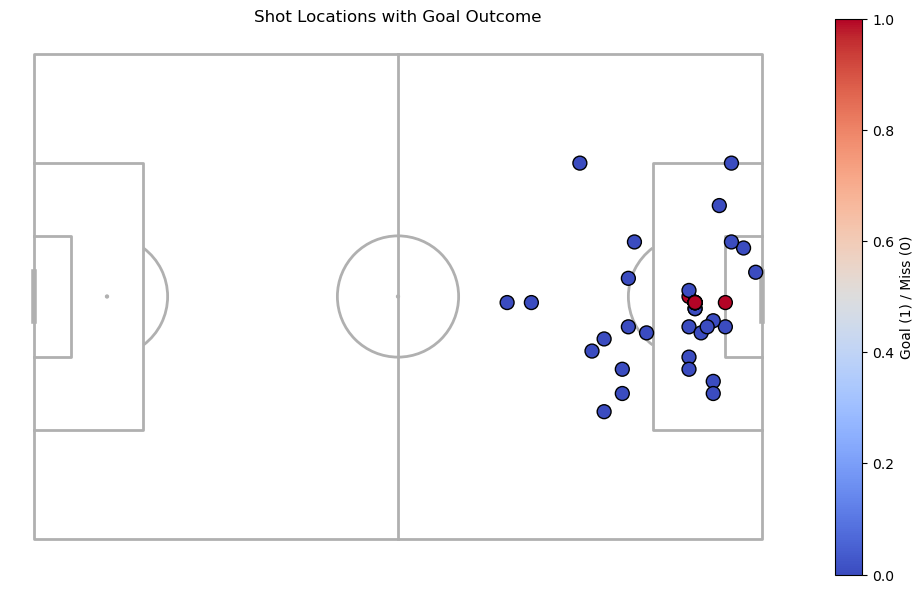

In [1]:
# Import necessary libraries
from statsbombpy import sb
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Load the competition and match data to access events
competition_id = 43  # Example competition (e.g., Women's World Cup)
season_id = 3  # Example season (e.g., 2019)
matches = sb.matches(competition_id=competition_id, season_id=season_id)

# Select a match to retrieve events for (replace with desired match_id)
match_id = matches['match_id'][0]
events = sb.events(match_id=match_id)

# Filter for shots only
shots = events[events['type'] == 'Shot'].copy()

# Feature Engineering
# Calculate the distance and angle to the goal for each shot
shots['goal_x'], shots['goal_y'] = 120, 40  # Coordinates for goal center
shots['shot_distance'] = np.sqrt((shots['location'].apply(lambda x: x[0]) - shots['goal_x'])**2 + 
                                 (shots['location'].apply(lambda x: x[1]) - shots['goal_y'])**2)
shots['shot_angle'] = np.arctan2(abs(shots['location'].apply(lambda x: x[1]) - shots['goal_y']), 
                                 shots['location'].apply(lambda x: x[0]))

# Encode the outcome as a binary target (1 if goal, 0 otherwise)
shots['goal'] = shots['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Select features and target variable
features = ['shot_distance', 'shot_angle']
X = shots[features]
y = shots['goal']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Visualize the predictions
pitch = Pitch(pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(10, 6))
sc = ax.scatter(shots['location'].apply(lambda x: x[0]), shots['location'].apply(lambda x: x[1]), 
                c=shots['goal'], cmap='coolwarm', s=100, edgecolors='black', linewidth=1)
plt.colorbar(sc, ax=ax, label='Goal (1) / Miss (0)')
plt.title("Shot Locations with Goal Outcome")
plt.show()


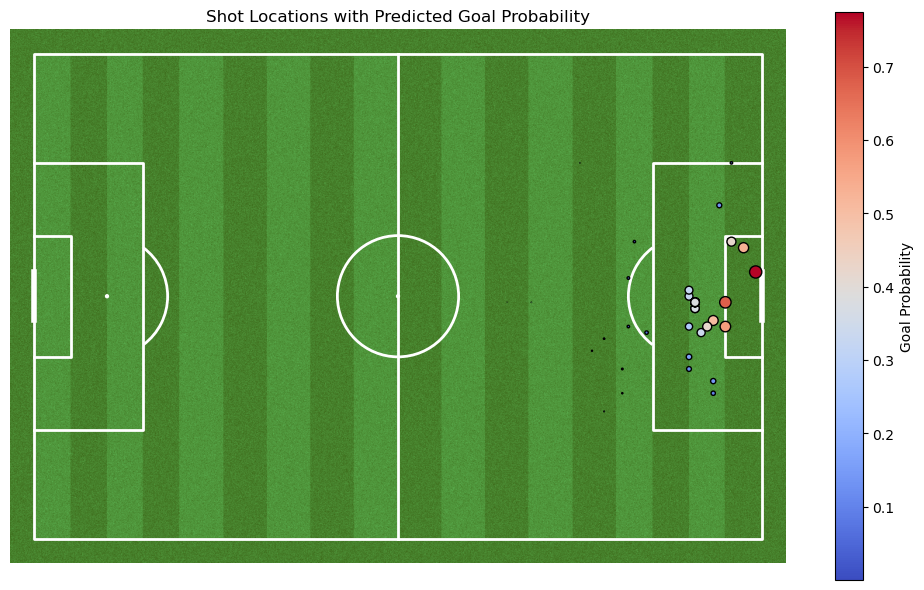

In [2]:
# Import necessary libraries
from statsbombpy import sb
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Load competition and match data
competition_id = 43  # Example competition ID
season_id = 3  # Example season ID
matches = sb.matches(competition_id=competition_id, season_id=season_id)

# Select a match to retrieve events for (replace with desired match_id)
match_id = matches['match_id'][0]
events = sb.events(match_id=match_id)

# Filter for shots only
shots = events[events['type'] == 'Shot'].copy()

# Feature Engineering
# Calculate the distance and angle to the goal for each shot
shots['goal_x'], shots['goal_y'] = 120, 40  # Coordinates for goal center
shots['shot_distance'] = np.sqrt((shots['location'].apply(lambda x: x[0]) - shots['goal_x'])**2 + 
                                 (shots['location'].apply(lambda x: x[1]) - shots['goal_y'])**2)
shots['shot_angle'] = np.arctan2(abs(shots['location'].apply(lambda x: x[1]) - shots['goal_y']), 
                                 shots['location'].apply(lambda x: x[0]))

# Encode the outcome as a binary target (1 if goal, 0 otherwise)
shots['goal'] = shots['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Select features and target variable
features = ['shot_distance', 'shot_angle']
X = shots[features]
y = shots['goal']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities on entire dataset for visualization
shots['goal_probability'] = model.predict_proba(X)[:, 1]

# Visualize using mplsoccer
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(10, 6))

# Scatter plot with shot location, size by goal probability, color by outcome
sc = pitch.scatter(shots['location'].apply(lambda x: x[0]), shots['location'].apply(lambda x: x[1]),
                   c=shots['goal_probability'], s=shots['goal_probability']*100, cmap='coolwarm', edgecolors='black',
                   ax=ax)
plt.colorbar(sc, ax=ax, label='Goal Probability')
plt.title("Shot Locations with Predicted Goal Probability")
plt.show()


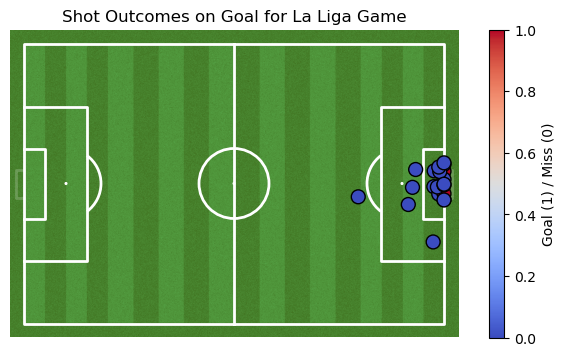

In [4]:
# Import necessary libraries
from statsbombpy import sb
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import numpy as np
import pandas as pd

# Load competition and match data for La Liga
competition_id = 11  # La Liga competition ID in StatsBomb
season_id = 4  # Example season (e.g., 2020-2021)
matches = sb.matches(competition_id=competition_id, season_id=season_id)

# Select a specific match (e.g., first available)
match_id = matches['match_id'][0]
events = sb.events(match_id=match_id)

# Filter for shots only
shots = events[events['type'] == 'Shot'].copy()

# Filter only shots with recorded end locations (e.g., shots on target)
goal_shots = shots[shots['shot_end_location'].notna()]

# Extract end location coordinates
goal_shots['end_x'] = goal_shots['shot_end_location'].apply(lambda x: x[0])
goal_shots['end_y'] = goal_shots['shot_end_location'].apply(lambda x: x[1])

# Encode the outcome as a binary target (1 if goal, 0 otherwise)
goal_shots['goal'] = goal_shots['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Goalpost View Visualization
# Set up a 'goal' plot (representing the goal from a front view)
goal_fig, goal_ax = plt.subplots(figsize=(8, 4))
pitch = Pitch(goal_type='box', pitch_color='grass', line_color='white', stripe=True, goal_alpha=0.2)
pitch.draw(goal_ax)  # Draw only on goal_ax (the axis)

# Plot shot end locations on the goal
sc = goal_ax.scatter(goal_shots['end_x'], goal_shots['end_y'], 
                     c=goal_shots['goal'], cmap='coolwarm', s=100, edgecolors='black')
plt.colorbar(sc, ax=goal_ax, label='Goal (1) / Miss (0)')
plt.title("Shot Outcomes on Goal for La Liga Game")
plt.show()
